In [1]:
import os
import time
import numpy as np
import pandas as pd
import zarr
import h5py
from netCDF4 import Dataset
import pyarrow.parquet as pq
import pyarrow.feather as feather
import shutil
import pickle
import json
import pyarrow as pa
import xarray as xr
import matplotlib.pyplot as plt

In [ ]:
def measure_time(func, *args, **kwargs):
    start = time.perf_counter()
    result = func(*args, **kwargs)
    end = time.perf_counter()
    elapsed_time = end - start
    return result, elapsed_time

def get_file_size(filepath):
    if os.path.isdir(filepath):
        total_size = 0
        for dirpath, dirnames, filenames in os.walk(filepath):
            for f in filenames:
                fp = os.path.join(dirpath, f)
                total_size += os.path.getsize(fp)
        return total_size / (1024 * 1024)
    else:
        return os.path.getsize(filepath) / (1024 * 1024)

fiber_files = [
    "fibers_1_20240514222825.npy",
    "fibers_1_20240514222634.npy",
    "fibers_1_20240514222444.npy",
    "fibers_1_20240514222253.npy",
    "fibers_1_20240514222103.npy",
]

output_dir = "output_files"
os.makedirs(output_dir, exist_ok=True)

# TXT Format
def write_txt(data, filepath):
    np.savetxt(filepath, data)

def read_txt(filepath):
    return np.loadtxt(filepath)

# CSV Format
def write_csv(data, filepath):
    pd.DataFrame(data).to_csv(filepath, index=False, header=False)

def read_csv(filepath):
    return pd.read_csv(filepath, header=None).values

# Parquet Format
def write_parquet(data, filepath):
    df = pd.DataFrame(data)
    df.to_parquet(filepath, index=False)

def read_parquet(filepath):
    return pd.read_parquet(filepath).values

# Feather Format

def write_feather(data, filepath):
    df = pd.DataFrame(data)
    feather.write_feather(df, filepath)

def read_feather(filepath):
    df = feather.read_feather(filepath)
    return df.values

# Zarr Format

def write_zarr(data, filepath, chunks=(100, 25000)):
    z = zarr.open(filepath, mode='w', shape=data.shape, chunks=chunks, dtype='f4')
    z[:] = data

def read_zarr(filepath):
    z = zarr.open(filepath, mode='r')
    return z[:]


# HDF5 Format

def write_hdf5(data, filepath):
    with h5py.File(filepath, 'w') as f:
        f.create_dataset('dataset', data=data, compression="gzip")

def read_hdf5(filepath):
    with h5py.File(filepath, 'r') as f:
        return f['dataset'][:]


# NetCDF Format

def write_netcdf(data, filepath):
    with Dataset(filepath, 'w', format="NETCDF4") as ds:
        ds.createDimension('dim0', data.shape[0])
        ds.createDimension('dim1', data.shape[1])
        var = ds.createVariable('data', 'f4', ('dim0', 'dim1'))
        var[:] = data

def read_netcdf(filepath):
    with Dataset(filepath, 'r') as ds:
        return ds.variables['data'][:]


# Pickle Format
def write_pickle(data, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)

def read_pickle(filepath):
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    return data


# JSON Format

def write_json(data, filepath):
    data_list = data.tolist()
    with open(filepath, 'w') as f:
        json.dump(data_list, f)

def read_json(filepath):
    with open(filepath, 'r') as f:
        data_list = json.load(f)
    return np.array(data_list)


# Execute Tests with Multiple Runs

formats = {
    "TXT": (write_txt, read_txt),
    "CSV": (write_csv, read_csv),
    "Parquet": (write_parquet, read_parquet),
    "Feather": (write_feather, read_feather),
    "Zarr": (write_zarr, read_zarr),
    "HDF5": (write_hdf5, read_hdf5),
    "NetCDF": (write_netcdf, read_netcdf),
    "Pickle": (write_pickle, read_pickle),
    "JSON": (write_json, read_json),
}

results = []
num_runs = 15

for fiber_file in fiber_files:
    data = np.load(fiber_file)
    for fmt, (write_func, read_func) in formats.items():
        extension = fmt.lower()
        if fmt == "Zarr":
            extension = "zarr"
        elif fmt == "Feather":
            extension = "feather"
        elif fmt == "Pickle":
            extension = "pkl"
        elif fmt == "JSON":
            extension = "json"
        output_path = os.path.join(output_dir, f"{os.path.splitext(fiber_file)[0]}.{extension}")
        
        write_times = []
        read_times = []
        for _ in range(num_runs):
            if os.path.exists(output_path):
                if os.path.isfile(output_path):
                    os.remove(output_path)
                elif os.path.isdir(output_path):
                    shutil.rmtree(output_path)
            try:
                _, write_time = measure_time(write_func, data, output_path)
                write_times.append(write_time)
            except Exception as e:
                print(f"Error writing {fmt} format for file {fiber_file}: {e}")
                break

        if not write_times:
            continue

        if not os.path.exists(output_path):
            try:
                write_func(data, output_path)
            except Exception as e:
                print(f"Error writing {fmt} format for file {fiber_file}: {e}")
                continue
        
        for _ in range(num_runs):
            try:
                _, read_time = measure_time(read_func, output_path)
                read_times.append(read_time)
            except Exception as e:
                print(f"Error reading {fmt} format for file {fiber_file}: {e}")
                break 

        if not read_times:
            continue

        avg_write_time = sum(write_times) / num_runs
        avg_read_time = sum(read_times) / num_runs

        file_size = get_file_size(output_path)
        
        results.append({
            "File": fiber_file,
            "Format": fmt,
            "Average Write Time (s)": avg_write_time,
            "Average Read Time (s)": avg_read_time,
            "Write Times (s)": write_times,
            "Read Times (s)": read_times,
            "File Size (MB)": file_size,
        })

results_df = pd.DataFrame(results)
print("Tests completed")


Tests completed


In [20]:
#delete the output files, could influence future tests if they remained open.
import shutil
directory_path = "output_files"
if os.path.exists(directory_path):
    shutil.rmtree(directory_path)
    print(f"{directory_path} and its contents have been deleted.")
else:
    print(f"{directory_path} does not exist.")


output_files and its contents have been deleted.


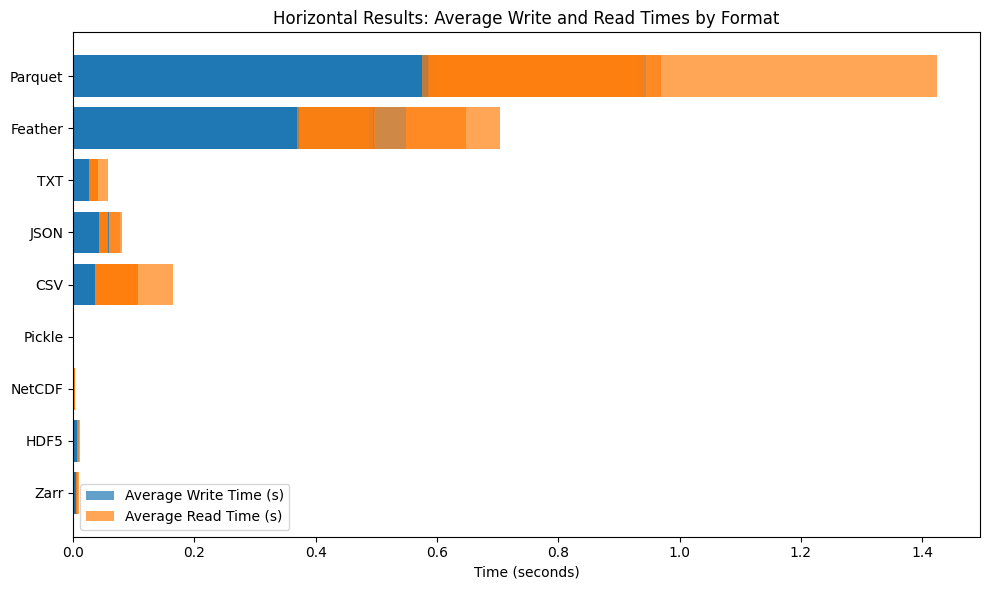

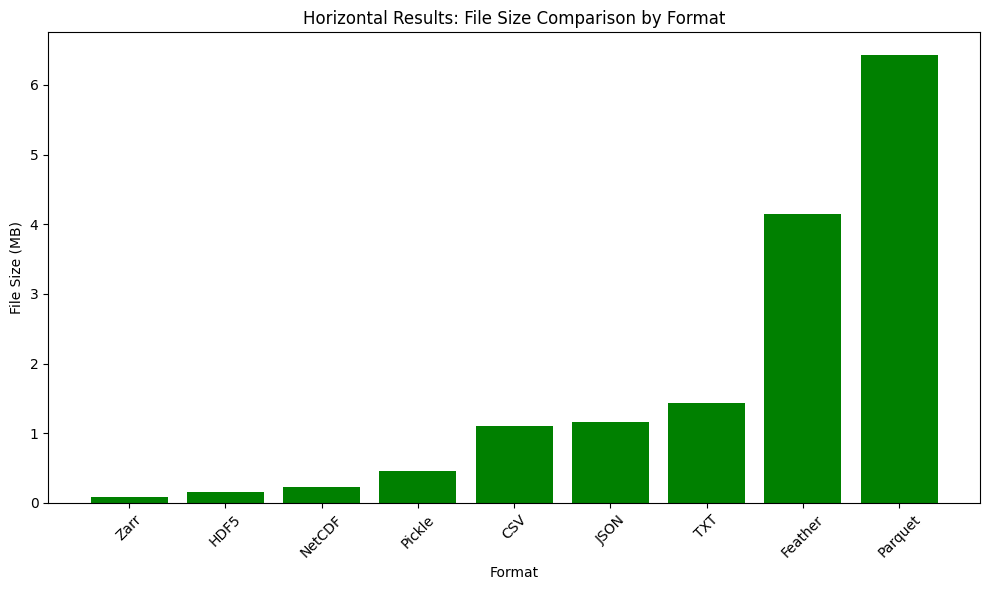

In [ ]:
plt.figure(figsize=(10, 6))
df = results_df.sort_values('File Size (MB)')

plt.barh(df['Format'], df['Average Write Time (s)'], label='Average Write Time (s)', alpha=0.7)
plt.barh(df['Format'], df['Average Read Time (s)'], label='Average Read Time (s)', alpha=0.7, left=df['Average Write Time (s)'])

plt.xlabel('Time (seconds)')
plt.title('Horizontal Results: Average Write and Read Times by Format')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(df['Format'], df['File Size (MB)'], color='green')
plt.xlabel('Format')
plt.ylabel('File Size (MB)')
plt.title('Horizontal Results: File Size Comparison by Format')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




In [30]:
paths = [
    "fibers_1_20240514222825.npy",
    "fibers_1_20240514222634.npy",
    "fibers_1_20240514222444.npy",
    "fibers_1_20240514222253.npy",
    "fibers_1_20240514222103.npy",
]
df_cleaned = pd.concat([load(path) for path in paths])

In [31]:
def measure_time(func, *args, **kwargs):
    start = time.perf_counter()
    result = func(*args, **kwargs)
    end = time.perf_counter()
    elapsed_time = end - start
    return result, elapsed_time

def get_file_size(filepath):
    if os.path.isdir(filepath):
        total_size = 0
        for dirpath, dirnames, filenames in os.walk(filepath):
            for f in filenames:
                fp = os.path.join(dirpath, f)
                total_size += os.path.getsize(fp)
        return total_size / (1024 * 1024)
    else:
        return os.path.getsize(filepath) / (1024 * 1024)

output_dir = "output_files"
os.makedirs(output_dir, exist_ok=True)

# TXT Format
def write_txt(data, filepath):
    data.to_csv(filepath, sep='\t', index=False, header=False)

def read_txt(filepath):
    return pd.read_csv(filepath, sep='\t', header=None)

# CSV Format
def write_csv(data, filepath):
    data.to_csv(filepath, index=False, header=False)

def read_csv(filepath):
    return pd.read_csv(filepath, header=None)

# Parquet Format
def write_parquet(data, filepath):
    table = pa.Table.from_pandas(data)
    pq.write_table(table, filepath)

def read_parquet(filepath):
    table = pq.read_table(filepath)
    return table.to_pandas()

# Feather Format
def write_feather(data, filepath):
    data.reset_index(drop=True).to_feather(filepath)

def read_feather(filepath):
    return pd.read_feather(filepath)

# Zarr Format

def write_zarr(data, filepath):
    import zarr
    data_dict = {col: data[col].values for col in data.columns}
    z = zarr.open(filepath, mode='w')
    for key, values in data_dict.items():
        z[key] = values

def read_zarr(filepath):
    import zarr
    z = zarr.open(filepath, mode='r')
    data_dict = {key: z[key][:] for key in z.array_keys()}
    return pd.DataFrame(data_dict)

# HDF5 Format
def write_hdf5(data, filepath):
    data.to_hdf(filepath, key='df', mode='w', format='table', complevel=9)

def read_hdf5(filepath):
    return pd.read_hdf(filepath, key='df')


# NetCDF Format
def write_netcdf(data, filepath):
    xr_data = xr.Dataset({'data': (('dim0', 'dim1'), data.values)})
    xr_data.to_netcdf(filepath)

def read_netcdf(filepath):
    xr_data = xr.open_dataset(filepath)
    return xr_data['data'].to_pandas()

# Pickle Format
def write_pickle(data, filepath):
    data.to_pickle(filepath)

def read_pickle(filepath):
    return pd.read_pickle(filepath)

# JSON Format
def write_json(data, filepath):
    data.to_json(filepath, orient='records')

def read_json(filepath):
    return pd.read_json(filepath, orient='records')

# Execute Tests with Multiple Runs
formats = {
    "TXT": (write_txt, read_txt),
    "CSV": (write_csv, read_csv),
    "Parquet": (write_parquet, read_parquet),
    "Feather": (write_feather, read_feather),
    "Zarr": (write_zarr, read_zarr),
    "HDF5": (write_hdf5, read_hdf5),
    "NetCDF": (write_netcdf, read_netcdf),
    "Pickle": (write_pickle, read_pickle),
    "JSON": (write_json, read_json),
}

results = []
num_runs = 15

data = df_cleaned

for fmt, (write_func, read_func) in formats.items():
    extension = fmt.lower()
    if fmt == "Zarr":
        extension = "zarr"
    elif fmt == "Feather":
        extension = "feather"
    elif fmt == "Pickle":
        extension = "pkl"
    elif fmt == "JSON":
        extension = "json"
    output_path = os.path.join(output_dir, f"df_cleaned.{extension}")
    
    write_times = []
    read_times = []
    for _ in range(num_runs):
        if os.path.exists(output_path):
            if os.path.isfile(output_path):
                os.remove(output_path)
            elif os.path.isdir(output_path):
                shutil.rmtree(output_path)
        try:
            _, write_time = measure_time(write_func, data, output_path)
            write_times.append(write_time)
        except Exception as e:
            print(f"Error writing {fmt} format: {e}")
            break

    if not write_times:
        continue

    if not os.path.exists(output_path):
        try:
            write_func(data, output_path)
        except Exception as e:
            print(f"Error writing {fmt} format: {e}")
            continue
    
    for _ in range(num_runs):
        try:
            _, read_time = measure_time(read_func, output_path)
            read_times.append(read_time)
        except Exception as e:
            print(f"Error reading {fmt} format: {e}")
            break
    if not read_times:
        continue

    avg_write_time = sum(write_times) / num_runs
    avg_read_time = sum(read_times) / num_runs

    file_size = get_file_size(output_path)
    
    results.append({
        "Format": fmt,
        "Average Write Time (s)": avg_write_time,
        "Average Read Time (s)": avg_read_time,
        "Write Times (s)": write_times,
        "Read Times (s)": read_times,
        "File Size (MB)": file_size,
    })

results_df_vertical = pd.DataFrame(results)
print("Tests completed")


Tests completed


In [34]:
#delete the output files, could influence future tests if they remained open.
import shutil
directory_path = "output_files"
if os.path.exists(directory_path):
    shutil.rmtree(directory_path)
    print(f"{directory_path} and its contents have been deleted.")
else:
    print(f"{directory_path} does not exist.")


output_files and its contents have been deleted.


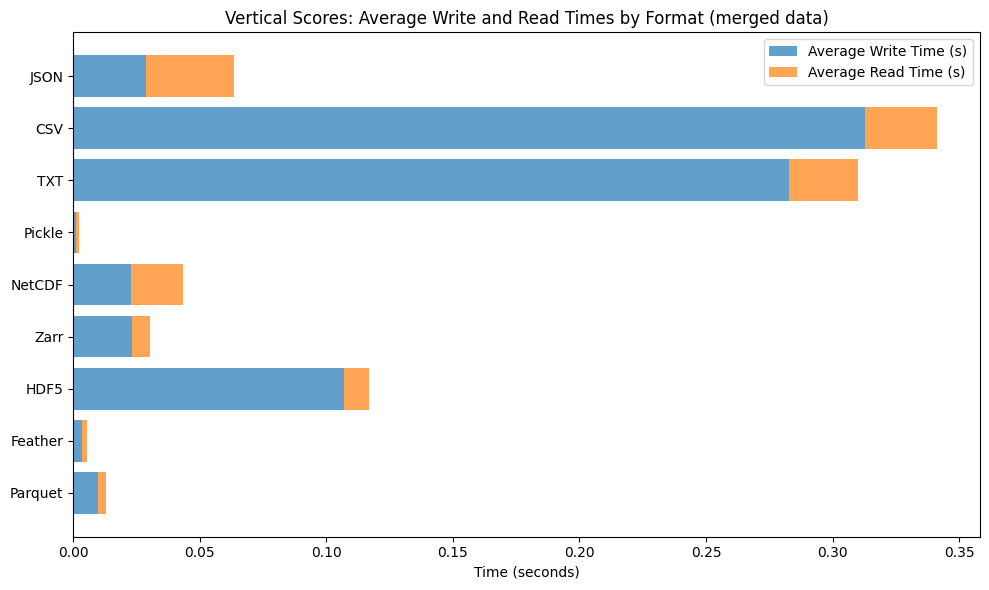

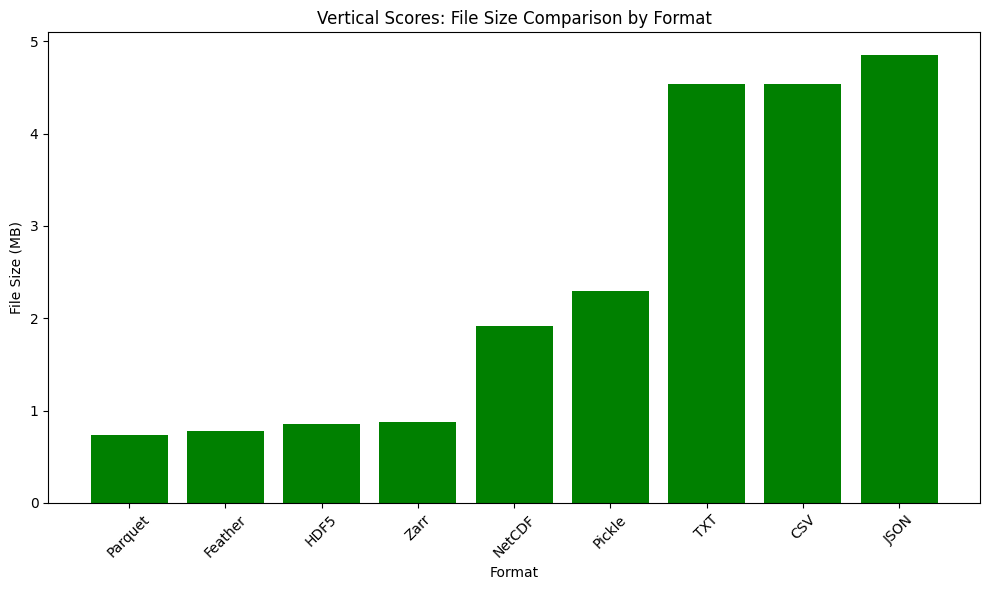

In [33]:
vertical_results_sorted = results_df_vertical.sort_values('File Size (MB)')
plt.figure(figsize=(10, 6))

plt.barh(vertical_results_sorted['Format'], vertical_results_sorted['Average Write Time (s)'], label='Average Write Time (s)', alpha=0.7)
plt.barh(vertical_results_sorted['Format'], vertical_results_sorted['Average Read Time (s)'], label='Average Read Time (s)', alpha=0.7, left=vertical_results_sorted['Average Write Time (s)'])

plt.xlabel('Time (seconds)')
plt.title('Vertical Scores: Average Write and Read Times by Format (merged data)')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(vertical_results_sorted['Format'], vertical_results_sorted['File Size (MB)'], color='green')
plt.xlabel('Format')
plt.ylabel('File Size (MB)')
plt.title('Vertical Scores: File Size Comparison by Format')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Let's take a closer look to the query times of Picle, NetCDF and Zarr.

Test have been done on a PC with the following specifications:

-   CPU : i7 14700K
-   GPU : RTX 3080
-   RAM : 64GB 6000MHz
-   SSD : Samsung 990 PRO 2tb 
    - Write speed : 6900 Megabytes Per Second
    - Read speed : 7450 Megabytes Per Second